# What's Cooking?

Ross Flieger-Allison, Will Richards

In [2]:
"""
Imports dependencies.

NOTE: Run this twice to get rid of the deprecation warning.
"""

%matplotlib inline
%load_ext ipycache
import re
import string
import time
import json
import distance
import numpy as np
import matplotlib.pyplot as plt
import sklearn.cross_validation as cv
from pandas import DataFrame
from sknn import mlp
from collections import OrderedDict
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVC
from sknn.backend import lasagne
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics

The ipycache extension is already loaded. To reload it, use:
  %reload_ext ipycache


In [3]:
"""
Loads in the training data file.
"""

with open('data/train.json') as data_file:    
    train_data = json.load(data_file)

---
## Initial Exploratory Data Analysis


In [4]:
"""
The number of recipes in the training dataset.
"""

print(len(train_data))

39774


In [5]:
"""
An example recipe.
"""

print(train_data[0])

{u'cuisine': u'greek', u'id': 10259, u'ingredients': [u'romaine lettuce', u'black olives', u'grape tomatoes', u'garlic', u'pepper', u'purple onion', u'seasoning', u'garbanzo beans', u'feta cheese crumbles']}


In [6]:
"""
Stores the cuisines and ingredients in separate variables (w/ duplicates).
"""

all_cuisines = []
all_ingredients = []

for recipe in train_data:
    all_cuisines.append(recipe['cuisine'])
    all_ingredients.extend(recipe['ingredients'])
    
all_cuisines = np.array(all_cuisines)
all_ingredients = np.array(all_ingredients)

In [7]:
"""
The first few cuisines (note the duplicates).
"""

for i in range(10):
    print(all_cuisines[i])

greek
southern_us
filipino
indian
indian
jamaican
spanish
italian
mexican
italian


In [8]:
"""
The first few ingredients (note the duplicates).
"""

for i in range(10):
    print(all_ingredients[i])

romaine lettuce
black olives
grape tomatoes
garlic
pepper
purple onion
seasoning
garbanzo beans
feta cheese crumbles
plain flour


In [9]:
"""
The average number of ingredients per recipe.
"""

print(len(all_ingredients) / len(train_data))

10


In [10]:
"""
Isolates only unique cuisines and ingredients and sort them alphabetically.
"""

unique_cuisines, cuisine_counts = np.unique(all_cuisines, return_counts=True)
unique_ingredients, ingredient_counts = np.unique(all_ingredients, return_counts=True)

In [11]:
"""
The number of unique cuisines.
"""

print(len(unique_cuisines))

20


In [12]:
"""
List of unique cuisines.
"""

for cuisine in unique_cuisines:
    print(cuisine)

brazilian
british
cajun_creole
chinese
filipino
french
greek
indian
irish
italian
jamaican
japanese
korean
mexican
moroccan
russian
southern_us
spanish
thai
vietnamese


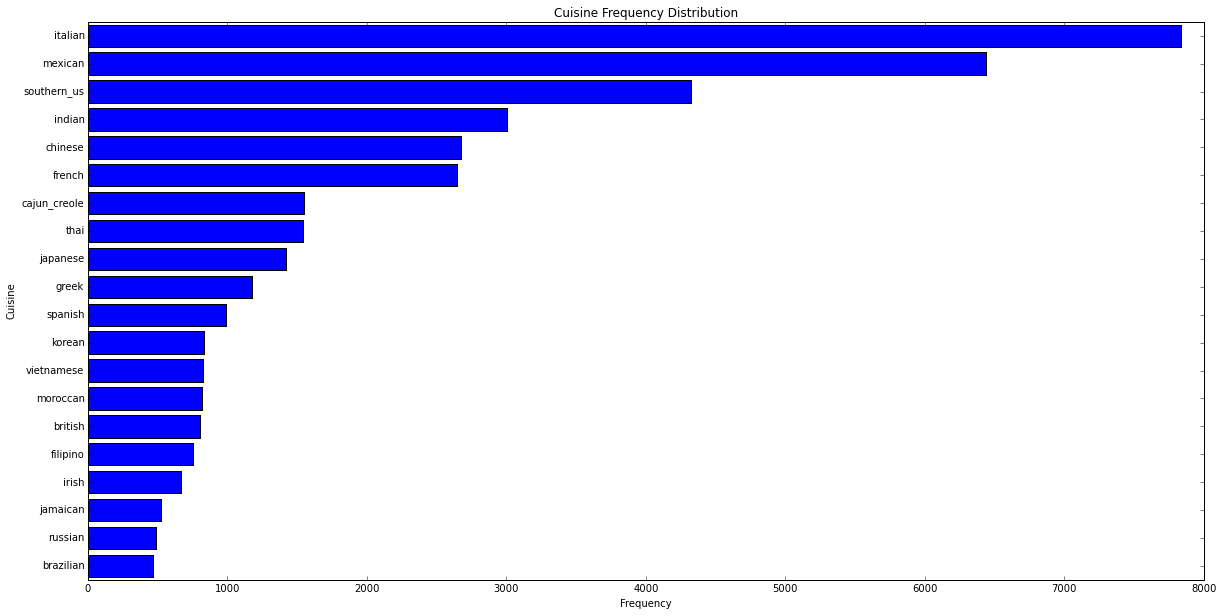

In [13]:
"""
Explore cuisine frequency in the dataset.
"""

# Sort the cuisines by frequency.
cuisine_counts, unique_cuisines = zip(*sorted(zip(cuisine_counts, unique_cuisines)))

# Plot the frequencies.
pos = np.arange(len(unique_cuisines)) + 0.5
plt.figure(figsize=(20, 10))
plt.barh(pos, cuisine_counts, align='center')
plt.yticks(pos, unique_cuisines)
plt.xlabel('Frequency')
plt.ylabel('Cuisine')
plt.title('Cuisine Frequency Distribution')
plt.show()

##### As you can see here, the cuisine frequency distribution appears to be close to exponential.

In [14]:
"""
Number of unique ingredients in the dataset.
"""

print(len(unique_ingredients))

6714


In [15]:
"""
Some example ingredients.
"""

for i in range(20):
    print(unique_ingredients[i])

(    oz.) tomato sauce
(   oz.) tomato paste
(10 oz.) frozen chopped spinach
(10 oz.) frozen chopped spinach, thawed and squeezed dry
(14 oz.) sweetened condensed milk
(14.5 oz.) diced tomatoes
(15 oz.) refried beans
1% low-fat buttermilk
1% low-fat chocolate milk
1% low-fat cottage cheese
1% low-fat milk
2 1/2 to 3 lb. chicken, cut into serving pieces
2% low fat cheddar chees
2% low-fat cottage cheese
2% lowfat greek yogurt
2% milk shredded mozzarella cheese
2% reduced-fat milk
25% less sodium chicken broth
33% less sodium cooked deli ham
33% less sodium cooked ham


---
## Data Cleaning


In [16]:
"""
Provides functions for removing unwanted noise from text.
"""

# Moving lists like this outside the function definition make the function code more readable and 
# less verbose.
character_exceptions_to_remove = ["\xae", "\xe8vre", "\u2122"]
phrase_exceptions = [("7 up", "sevenup"), ("sun dried", "sundried"), ("bone less", "boneless"), 
                     ("skin less", "skinless")]
map_plural_to_singular = [("steaks", "steak"), ("loins", "loin"), ("inches", "inch"), ("centimeters", "centimeter"),
                          ("ounces", "ounce"), ("liters", "liter"), ("mililiters", "mililiter"), ("grams", "gram"),
                          ("cups", "cup"), ("gallons", "gallon"), ("quarts", "quart"), ("lbs", "lb"),
                          ("pounds", "pound"), ("tablespoons", "tablespoon"), ("teaspoons", "teaspoon"), 
                          ("pints", "pint"), ("fluid ounces", "fluid ounce"), ("onions", "onion"), 
                          ("cloves", "clove"), ("bulbs", "bulb"), ("peppers", "pepper"), ("breasts", "breast"),
                          ("eggs", "egg"), ("carrots", "carrot"), ("mushrooms", "mushroom"),
                          ("tortillas", "tortilla"), ("sausages", "sausage"), ("wedges", "wedge"), 
                          ("tomatoes", "tomato"), ("thighs", "thigh"), ("chilies", "chili"), ("potatoes", "potato"), 
                          ("peppercorns", "peppercorn"), ("spices", "spice"), ("chiles", "chile"), ("apples", "apple"),
                          ("legs", "leg"), ("doughs", "dough"), ("drumsticks", "drumstick")]
brandnames_to_remove = ["alexia", "breakstones", "kraft", "bertolli classico", "bertolli", "best foods", 
                        "betty crocker", "bisquick", "bob evans", "breyers", "curry guy", "camellia", "campbells", 
                        "country crock", "crisco", "crystal farms", "delallo", "diamond crystal", "domino", 
                        "doritos", "earth balance", "egglands best", "foster farms", "franks", "gold medal", 
                        "goya", "green giant steamers niblets", "green giant", "heinz", "hellmanns", "herdez", 
                        "hidden valley", "honeysuckle white", "jacksonville",  "jimmy dean", "johnsonville", 
                        "knorr", "krudsen", "kikkoman", "lipton", "land o lakes", "mazola", "lea and perrins", 
                        "mccormick", "meyer", "mission", "old el paso", "old bay", "pam", "pepperidge farm", 
                        "oscar mayer", "pace", "pillsbury", "progresso", "pure wesson", "pompeian", "san marzano", 
                        "sargento", "soy vay", "taco bell", "yoplait", "spice islands", "stonefire", "success", 
                        "swanson", "truvía", "uncle bens", "wish bone", "zatarains", "morton", "jameson", "tapatio", 
                        "mountain high", "philadelphia", "king arthur", "roma"]
keywords_to_remove = ["lowfat", "light", "shredded", "sliced", "all purpose", "all natural", "natural", "original", 
                      "gourmet", "traditional", "boneless", "skinless", "fresh", "nonfat", "pitted", "quick cooking", 
                      "unbleached", "part skim", "skim", "quickcooking", "oven ready", "homemade", "instant", "small", 
                      "extra large", "large", "chopped", "grated", "cooked", "stone ground", "freshly ground", 
                      "ground", "pure", "peeled", "deveined", "organic", "cracked", "granulated", "inch thick", 
                      "extra firm", "crushed", "flakes", "self rising", "diced", "crumbles", "crumbled", 
                      "whole wheat", "whole grain", "baby", "medium", "plain", "of", "thick cut", "cubed", "coarse", 
                      "free range", "seasoned", "canned", "multipurpose", "vegan", "thawed", "squeezed", 
                      "vegetarian", "fine", "zesty", "halves", "firmly packed", "drain", "drained", "washed"]
measurements_to_remove = ["in", "inch", "cm", "centimeter", "oz", "ounce", "l", "liter", "ml", "mililiter", "g", 
                          "gram", "cup", "gallon", "quart", "lb", "pound", "tbsp", "tablespoon", "tsp", "teaspoon", 
                          "pint", "fl oz", "fluid ounce"]
phrases_to_remove = measurements_to_remove + keywords_to_remove + brandnames_to_remove
phrases_to_map = [
    (("green onion", "red onion", "purple onion", "yellow onion", "yel onion"), "onion"),
    (("collard green leaves", "collards", "collard leaves"), "collard greens"),
    ("black pepper", "pepper"),
    ("yel chives", "chives"),
    ("spinach leaves", "spinach"),
    ("tea leaves", "tea"),
    ("chile", "chili"),
    (("garlic clove", "garlic bulb"), "garlic"),
    ("uncooked", "raw"),
    (("red chili pepper", "hot chili pepper", "red hot chili pepper"), "chili pepper"),
    (("baking potato", "baked potato"), "baked potato"),
    (("sea salt", "kosher salt", "table salt", "white salt"), "salt"),
    ("scotch whiskey", "scotch"),
    (("i cant believe its not butter spread", "i cant believe its not butter"), "butter"),
    (("extra virgin olive oil", "virgin olive oil"), "olive oil"),
    (("white bread", "wheat bread", "grain bread"), "bread"),
    (("white sugar", "yel sugar"), "sugar"),
    ("confectioners sugar", "powdered sugar")
]

# When executing multiple regex parses, it's most efficient to compile the expression ahead of time.
punctuation_to_replace_with_space = re.compile(r"[-,]")
percentage_less_to_remove = re.compile(r"[\d+]% less [A-z]*")
percentage_reduced_to_remove = re.compile(r"[\d+]% reduced [A-z]*")
symbols_to_remove = re.compile(r"[!\\/%.'®™]")
digits_to_remove = re.compile(r"\d+")
symbols_to_replace_with_and = re.compile(r"[&+]")
parentheses_content_to_remove = re.compile(r"\([^)]*\)")
no_blank_added_to_remove = re.compile(r"no [A-z]* added")
reduced_and_following_word_to_remove = re.compile(r"reduced [A-z]*")
low_and_following_word_to_remove = re.compile(r"low [A-z]*")
less_and_following_word_to_remove = re.compile(r"less [A-z]*")
free_and_previous_word_to_remove = re.compile(r"[A-z]* free")
multiple_spaces_to_trim = re.compile(r" +")


def clean_ingredient(ingredient):
    """
    Removes unnecessary noise from the inputted text.
    """
    
    # Convert to lowercase.
    ingredient = ingredient.lower()
    
    # Replace hyphens and commas with spaces.
    ingredient = punctuation_to_replace_with_space.sub(" ", ingredient)
    
    # Map certain exceptions that we don't want whiped out by later cleaning processes.
    for character_exception in character_exceptions_to_remove:
        ingredient = re.sub(character_exception, "", ingredient)
    for phrase_exception, replacement in phrase_exceptions:
        ingredient = re.sub(r"\b{}\b".format(phrase_exception), replacement, ingredient)
        
    # Remove "percentage less" instances (e.g., "40% less sodium") - do this before removing % and digits.
    ingredient = percentage_less_to_remove.sub("", ingredient)
    
    # Remove "percentage reduced" instances (e.g., "50% reduced fat") - do this before removing % and digits.
    ingredient = percentage_reduced_to_remove.sub("", ingredient)
    
    # Remove various unwanted symbols.
    ingredient = symbols_to_remove.sub("", ingredient)
    
    # Remove digits.
    ingredient = digits_to_remove.sub("", ingredient)
    
    # Replace common symbols with their word equivalent (so "Ben&Jerry's" == "Ben and Jerry's", etc.).
    ingredient = symbols_to_replace_with_and.sub(" and ", ingredient)
    
    # Remove anything between parentheses (this mainly includes volume measurements or 
    # unnecessary cooking instructions).
    ingredient = parentheses_content_to_remove.sub(" ", ingredient)
    
    # Remove all instances of 'no [sugar, sodium, fat, whatever] added'.
    ingredient = no_blank_added_to_remove.sub("", ingredient)
    
    # Remove any instance of 'reduced' and the word after it (e.g., 'reduced sodium').
    ingredient = reduced_and_following_word_to_remove.sub("", ingredient)
    
    # Remove any instance of 'low' and the word after it (e.g., 'low fat', 'low sodium').
    ingredient = low_and_following_word_to_remove.sub("", ingredient)
    
    # Remove any instance of 'less' and the word after it (e.g., 'less sodium').
    ingredient = less_and_following_word_to_remove.sub("", ingredient)
    
    # Remove and instance of 'free' and the word before it (e.g., 'sugar free', 'sodium free')
    ingredient = free_and_previous_word_to_remove.sub("", ingredient)
    
    # Remove excess spacing in between words after first cleaning pass.
    ingredient = multiple_spaces_to_trim.sub(" ", ingredient)
    
    # Map common plural ingredients to singular ingredients (e.g., "tomatoes" == "tomato").
    for plural, singular in map_plural_to_singular:
        ingredient = re.sub(r"\b{}\b".format(plural), singular, ingredient)
        
    # Remove unuseful words (e.g., "natural", "all-purpose", etc.).
    for phrase in phrases_to_remove:
        ingredient = re.sub(r"\b{}\b".format(phrase), "", ingredient)
    
    # Map several similar phrases to the other equivalents to maintain consistency.
    for pattern, replacement in phrases_to_map:
        if type(pattern) is tuple:
            for val in pattern:
                ingredient = re.sub(r"\b{}\b".format(val), replacement, ingredient)
        elif type(pattern) is str:
            ingredient = re.sub(r"\b{}\b".format(pattern), replacement, ingredient)
    
    # Remove excess spacing in between words after second cleaning pass and leading/trailing whitespace.
    ingredient = multiple_spaces_to_trim.sub(" ", ingredient)
    ingredient = ingredient.strip()
    
    return ingredient


def clean_recipe(recipe):
    """
    Cleans all the ingredients in a single recipe.
    """
    
    # Map the clean function to every ingredient in the recipe.
    recipe['ingredients'] = map(clean_ingredient, recipe['ingredients'])
    
    # Make sure post-cleaning empty strings are removed.
    recipe['ingredients'] = [ingredient for ingredient in recipe['ingredients'] if len(ingredient) > 0]
    
    return recipe


def clean_raw_data(raw_data):
    """
    Cleans all the recipes in the dataset by mapping each recipe to a clean function.
    """
    
    # Map a recipe-cleaning function to every recipe in the data.
    clean_data = np.array(map(clean_recipe, raw_data))
    
    return clean_data

In [17]:
%%cache -f clean_train_data.pkl train_data

# Use the following in replacement of the above line for storing newly cleaned data.
# %%cache --force clean_train_data.pkl train_data

"""
WARNING:
========
THIS CAN TAKE UP TO 2 HOURS TO COMPLETE!

If data has already been cleaned and cached, it just retrieved the cached data.

NOTE: If you want to re-clean and cache the data, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the cleaning procedure.
start_time = time.time()
train_data = clean_raw_data(train_data)
print("\nTime spent cleaning: {0:.3f} min.".format((time.time() - start_time) / float(60)))

[Saved variables train_data to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/clean_train_data.pkl'.]

Time spent cleaning: 80.020 min.


---
## Cleaned Data Analysis


In [18]:
"""
Shows how many noisy ingredients were removed/consolidated by cleaning.
"""

clean_ingredients = []

for recipe in train_data:
    clean_ingredients.extend(recipe['ingredients'])

print("Noisy ingredients consolidated: {}".format(len(unique_ingredients) - len(np.unique(clean_ingredients))))

Noisy ingredients consolidated: 1085


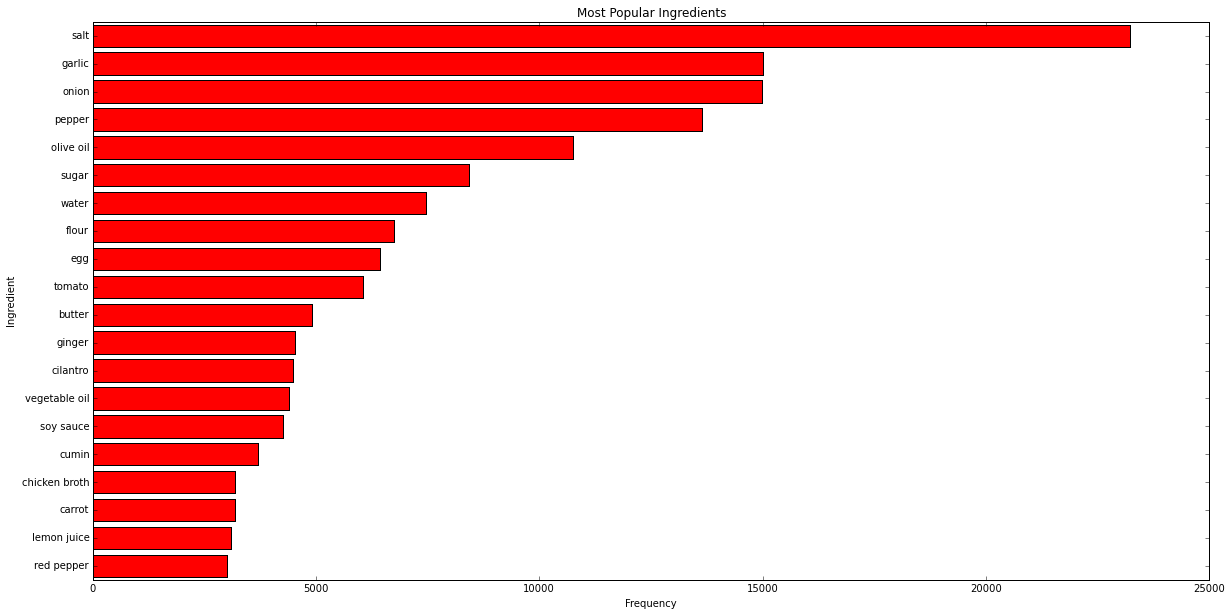

In [19]:
"""
Explores ingredient frequency in the dataset.
"""

# Get unique ingredients and their frequencies.
unique_clean_ingredients, clean_ingredient_counts = np.unique(clean_ingredients, return_counts=True)

# Sort the ingredients by frequency.
clean_ingredient_counts, unique_clean_ingredients = zip(*sorted(zip(clean_ingredient_counts, unique_clean_ingredients)))

# Only plot the most popular ingredients.
most_popular_unique_clean_ingredients = unique_clean_ingredients[-20:]
most_popular_clean_ingredient_counts = clean_ingredient_counts[-20:]

# Plot the frequencies.
pos = np.arange(len(most_popular_unique_clean_ingredients)) + 0.5
plt.figure(figsize=(20, 10))
plt.barh(pos, most_popular_clean_ingredient_counts, align='center', color='red')
plt.yticks(pos, most_popular_unique_clean_ingredients)
plt.xlabel('Frequency')
plt.ylabel('Ingredient')
plt.title('Most Popular Ingredients')
plt.show()

##### The ingredient frequency distribution also appears to be close to exponential, similar to the cuisine frequency distribution.

---
## Data Transformation


In [20]:
def build_vectorized_recipe_matrix(data):
    """
    Takes the recipes and produces an UNCONDENSED matrix where each row represents a recipe
    and each column represents the presence of an ingredient.
    """
    
    # Define a stop character to append recipe ingredients together into a single string.
    stopchar = '|'
    
    # Join the recipe ingredients.
    recipe_matrix_in_strings = [stopchar.join(recipe['ingredients']) for recipe in data]

    # Define a vectorizer object.
    vectorizer = CountVectorizer(binary=True, vocabulary=unique_clean_ingredients, token_pattern='[^|]+')
    
    # Vectorize the data.
    recipe_matrix = vectorizer.fit_transform(recipe_matrix_in_strings).toarray()
    
    return recipe_matrix

In [21]:
"""
Transforms the data into a binary matrix.
"""

# Transform it.
vectorized_matrix = build_vectorized_recipe_matrix(train_data)

# Look at what happened.
print("Number of recipes (represented as rows): {}".format(len(train_data)))
print("Number of unique cleaned ingredients (represented as columns): {}".format(len(unique_clean_ingredients)))
print("Dimensions of binary recipe matrix: {}".format(vectorized_matrix.shape))
print("Matrix representation: \n{}".format(vectorized_matrix))

Number of recipes (represented as rows): 39774
Number of unique cleaned ingredients (represented as columns): 5629
Dimensions of binary recipe matrix: (39774, 5629)
Matrix representation: 
[[0 0 0 ..., 1 1 0]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 ..., 
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 0 0 1]
 [0 0 0 ..., 1 1 1]]


In [22]:
"""
Checks the first recipe to confirm that things worked correctly.
"""

print("First recipe in original data:")
for ingredient in sorted(train_data[0]['ingredients']):
    print("\t" + ingredient)

print("First record in binary matrix:")
(rows, cols) = vectorized_matrix.shape
first_record = sorted([unique_clean_ingredients[i] for i in range(cols) if vectorized_matrix[0, i] == 1])
for ingredient in first_record:
    print("\t" + ingredient)

First recipe in original data:
	black olives
	feta cheese
	garbanzo beans
	garlic
	grape tomato
	onion
	pepper
	romaine lettuce
	seasoning
First record in binary matrix:
	black olives
	feta cheese
	garbanzo beans
	garlic
	grape tomato
	onion
	pepper
	romaine lettuce
	seasoning


##### While this should work fine, the resulting matrix is too big to be useful, so we need to condense things by using a sparse matrix representation.

In [23]:
def build_csr_sparse_recipe_matrix(data):
    """
    Takes the recipes and produces a sparse matrix in Condensed Row format 
    where each row represents a recipe and each column represents an ingredient.
    
    The idea behind doing this is to improve speed when building and using models.
    """
    
    # Defines an ingredient-index dictionary to help to build our matrix.
    ingredient_dict = dict(zip(unique_clean_ingredients, range(len(unique_clean_ingredients))))
    
    # Temporarily store the nonzero elements of the sparse matrix.
    row_index_vector = []
    col_index_vector = []
    value_vector = []
    
    # Iterate through the data and construct the necessary index and value vectors.
    for row in range(len(data)):
        for i in range(len(data[row]['ingredients'])):
            col = ingredient_dict[data[row]['ingredients'][i]]
            row_index_vector.append(row)
            col_index_vector.append(col)
            value_vector.append(True)
            
    # Build the sparse matrix using the three vectors populated above.
    sparse_matrix = csr_matrix((value_vector, (row_index_vector, col_index_vector)), dtype=np.bool)
    
    return sparse_matrix

In [24]:
"""
Transforms the data into a more efficient, sparse matrix.
"""

# Transform it.
csr_sparse_matrix = build_csr_sparse_recipe_matrix(train_data)

# Look at what happened.
print("Number of recipes (represented as rows): {}".format(len(train_data)))
print("Number of unique cleaned ingredients (represented as columns): {}".format(len(unique_clean_ingredients)))
print("Dimensions of sparse recipe matrix: {}".format(csr_sparse_matrix.shape))
print("Matrix representation (notice it only keeps track of True instances): \n{}".format(csr_sparse_matrix))

Number of recipes (represented as rows): 39774
Number of unique cleaned ingredients (represented as columns): 5629
Dimensions of sparse recipe matrix: (39774, 5629)
Matrix representation (notice it only keeps track of True instances): 
  (0, 5225)	True
  (0, 5344)	True
  (0, 5357)	True
  (0, 5382)	True
  (0, 5473)	True
  (0, 5510)	True
  (0, 5625)	True
  (0, 5626)	True
  (0, 5627)	True
  (1, 5128)	True
  (1, 5431)	True
  (1, 5559)	True
  (1, 5608)	True
  (1, 5615)	True
  (1, 5619)	True
  (1, 5620)	True
  (1, 5621)	True
  (1, 5625)	True
  (1, 5628)	True
  (2, 2913)	True
  (2, 4940)	True
  (2, 5486)	True
  (2, 5527)	True
  (2, 5571)	True
  (2, 5580)	True
  :	:
  (39772, 5432)	True
  (39772, 5462)	True
  (39772, 5542)	True
  (39772, 5543)	True
  (39772, 5588)	True
  (39772, 5592)	True
  (39772, 5593)	True
  (39772, 5597)	True
  (39772, 5600)	True
  (39772, 5617)	True
  (39772, 5621)	True
  (39772, 5623)	True
  (39772, 5628)	True
  (39773, 5571)	True
  (39773, 5577)	True
  (39773, 5581)	Tr

In [25]:
"""
Checks the first recipe to confirm that things worked correctly.
"""

print("First recipe in original data:")
for ingredient in sorted(train_data[0]['ingredients']):
    print("\t" + ingredient)
    
print("First record in sparse matrix:")
first_row_dense_matrix = np.asarray(csr_sparse_matrix.getrow(0).todense())
for recipe in first_row_dense_matrix:
    indices = np.where(recipe)[0]
    first_record = sorted([unique_clean_ingredients[i] for i in indices])
    for ingredient in first_record:
        print("\t" + ingredient)

First recipe in original data:
	black olives
	feta cheese
	garbanzo beans
	garlic
	grape tomato
	onion
	pepper
	romaine lettuce
	seasoning
First record in sparse matrix:
	black olives
	feta cheese
	garbanzo beans
	garlic
	grape tomato
	onion
	pepper
	romaine lettuce
	seasoning


---
## Data Classification


### Classifier Evaluation Utilities:

In [26]:
"""
Some utilities for fitting and building our classifiers.
"""


# Define the cuisine classifier labels with a more sensible variable name than 'all_cuisines'.
cuisine_labels = all_cuisines

# Metrics for predictors.
n_features = csr_sparse_matrix.shape[1]
n_targets = len(set(all_cuisines))


def kfold_fit(data_matrix, labels, classifier, n_folds=3):
    """
    Performs manual cross-validation given a matrix of data, labels, 
    and a predictive model.
    """
    
    # Define a K-fold for the given matrix dimensions.
    (num_rows, num_cols) = np.shape(data_matrix)
    kf = cv.KFold(num_rows, n_folds=n_folds)

    # Iterator of folds.
    for train, test in kf:

        # Define the training and test data and labels for this fold.
        data_train = data_matrix[train]
        data_test = data_matrix[test]
        labels_train = labels[train]
        labels_test = labels[test]

    # Fit the classifier.
    classifier.fit(data_train, labels_train)
        
    return classifier


def evaluate(classifier, sample_size=39774):
    """
    Returns the accuracy of a given model.
    
    Default sample is the entire dataset.
    """
    
    # Take a random sample so the evaluation doesn't take forever.
    sample_indices = np.random.choice(len(all_cuisines), sample_size)
    
    # Correct labels.
    y_true = all_cuisines[sample_indices]
    
    # Predicted labels.
    y_pred = classifier.predict(csr_sparse_matrix[sample_indices])
    
    # Proportion predicted correctly.
    accuracy = metrics.accuracy_score(y_true, y_pred)
    
    return accuracy

### KNN Classifier:

In [27]:
%%cache fitted_knn_classifier.pkl knn

# Use the following in replacement of the above line for storing a newly fitted model.
# %%cache --force fitted_knn_classifier.pkl knn

"""
If the model have already been fitted, this will simply returned the cached model.

NOTE: If you want to re-fit and cache the classifier, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the k-fold fitting procedure.
start_time = time.time()
knn_classifier = OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5, metric='minkowski'))
knn = kfold_fit(csr_sparse_matrix, cuisine_labels, knn_classifier)
print("\nTime spent fitting model: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(knn)

[Saved variables knn to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_knn_classifier.pkl'.]

Time spent fitting model: 0.002 min.
OneVsRestClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=5, p=2, weights='uniform'),
          n_jobs=1)


In [28]:
%%cache fitted_knn_accuracy.pkl knn_accuracy

# Use the following in replacement of the above line for storing a newly evaluated model accuracy.
# %%cache --force fitted_knn_accuracy.pkl knn_accuracy

"""
If the accuracy have already been calculated, this will simply returned the cached value.

NOTE: If you want to re-evaluate and cache the accuracy, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the training evaluating process.
start_time = time.time()
knn_accuracy = evaluate(knn, sample_size=1000)
print("\nTime spent making predictions: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(knn_accuracy)

[Saved variables knn_accuracy to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_knn_accuracy.pkl'.]

Time spent making predictions: 0.359 min.
0.635


##### As you can see, KNN performs very poorly on our training data. Additionally, while the building process doesn't take very long, the predicting process takes an extremely long time on large data, so a sample size of only 1000 was used for model evaluation in this example.

### Decision Tree Classifier:

In [29]:
%%cache fitted_dt_classifier.pkl dt

# Use the following in replacement of the above line for storing a newly fitted model.
# %%cache --force fitted_dt_classifier.pkl dt

"""
WARNING:
========
THIS CAN TAKE UP TO 20 MINUTES TO COMPLETE.

If the model have already been fitted, this will simply returned the cached model.

NOTE: If you want to re-fit and cache the classifier, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the decision tree fitting procedure.
start_time = time.time()
dt_classifier = OneVsRestClassifier(DecisionTreeClassifier())
dt = kfold_fit(csr_sparse_matrix, cuisine_labels, dt_classifier)
print("\nTime spent fitting model: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(dt)

[Saved variables dt to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_dt_classifier.pkl'.]

Time spent fitting model: 16.616 min.
OneVsRestClassifier(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best'),
          n_jobs=1)


In [30]:
%%cache fitted_dt_accuracy.pkl dt_accuracy

# Use the following in replacement of the above line for storing a newly evaluated model accuracy.
# %%cache --force fitted_dt_accuracy.pkl dt_accuracy

"""
If the accuracy have already been calculated, this will simply returned the cached value.

NOTE: If you want to re-evaluate and cache the accuracy, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the training evaluating process.
start_time = time.time()
dt_accuracy = evaluate(dt)
print("\nTime spent making predictions: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(dt_accuracy)

[Saved variables dt_accuracy to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_dt_accuracy.pkl'.]

Time spent making predictions: 0.006 min.
0.86292552924


##### DT performs moderately well but with a very slow build time.

### Random Forest Classifier:

In [31]:
%%cache fitted_rf_classifier.pkl rf

# Use the following in replacement of the above line for storing a newly fitted model.
# %%cache --force fitted_rf_classifier.pkl rf

"""
If the model have already been fitted, this will simply returned the cached model.

NOTE: If you want to re-fit and cache the classifier, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the random forest fitting procedure.
start_time = time.time()
rf_classifier = RandomForestClassifier()
rf = kfold_fit(csr_sparse_matrix, cuisine_labels, rf_classifier)
print("\nTime spent fitting model: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(rf)

[Saved variables rf to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_rf_classifier.pkl'.]

Time spent fitting model: 0.117 min.
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [32]:
%%cache fitted_rf_accuracy.pkl rf_accuracy

# Use the following in replacement of the above line for storing a newly evaluated model accuracy.
# %%cache --force fitted_rf_accuracy.pkl rf_accuracy

"""
If the accuracy have already been calculated, this will simply returned the cached value.

NOTE: If you want to re-evaluate and cache the accuracy, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the training evaluating process.
start_time = time.time()
rf_accuracy = evaluate(rf)
print("\nTime spent making predictions: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(rf_accuracy)

[Saved variables rf_accuracy to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_rf_accuracy.pkl'.]

Time spent making predictions: 0.006 min.
0.885452808367


##### RT performs the best so far but is slow and takes up MASSIVE amounts of storage as the number of estimators used when building the classifier increases (500 estimators yields ~0.906 accuracy but w/ 10 minutes build time and 10GB storage overhead!).

### SVM Classifier:

In [33]:
%%cache fitted_svm_classifier.pkl svm

# Use the following in replacement of the above line for storing a newly fitted model.
# %%cache --force fitted_svm_classifier.pkl svm

"""
If the model have already been fitted, this will simply returned the cached model.

NOTE: If you want to re-fit and cache the classifier, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the SVM fitting procedure.
start_time = time.time()
svm_classifier = LinearSVC(multi_class='ovr')
svm = kfold_fit(csr_sparse_matrix, cuisine_labels, svm_classifier)
print("\nTime spent fitting model: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(svm)

[Saved variables svm to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_svm_classifier.pkl'.]

Time spent fitting model: 0.074 min.
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)


In [34]:
%%cache fitted_svm_accuracy.pkl svm_accuracy

# Use the following in replacement of the above line for storing a newly evaluated model accuracy.
# %%cache --force fitted_svm_accuracy.pkl svm_accuracy

"""
If the accuracy have already been calculated, this will simply returned the cached value.

NOTE: If you want to re-evaluate and cache the accuracy, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the training evaluating process.
start_time = time.time()
svm_accuracy = evaluate(svm)
print("\nTime spent making predictions: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(svm_accuracy)

[Saved variables svm_accuracy to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_svm_accuracy.pkl'.]

Time spent making predictions: 0.001 min.
0.869663599336


##### SVM performs well and is fast and efficient, but ultimately doesn't produce the best results (so far RT is still the best). Note: all other forms of SVMs were tried (rbf, poly, etc.) and LinearSVC produced the best results, so it is the only model reported here.

### Logistic Regression:

In [35]:
%%cache fitted_lr_classifier.pkl lr

# Use the following in replacement of the above line for storing a newly fitted model.
# %%cache --force fitted_lr_classifier.pkl lr

"""
If the model have already been fitted, this will simply returned the cached model.

NOTE: If you want to re-fit and cache the classifier, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the logistic regression fitting procedure.
start_time = time.time()
lr_classifier = LogisticRegression()
lr = kfold_fit(csr_sparse_matrix, cuisine_labels, lr_classifier)
print("\nTime spent fitting model: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(lr)

[Saved variables lr to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_lr_classifier.pkl'.]

Time spent fitting model: 0.129 min.
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)


In [36]:
%%cache fitted_lr_accuracy.pkl lr_accuracy

# Use the following in replacement of the above line for storing a newly evaluated model accuracy.
# %%cache --force fitted_lr_accuracy.pkl lr_accuracy

"""
If the accuracy have already been calculated, this will simply returned the cached value.

NOTE: If you want to re-evaluate and cache the accuracy, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the training evaluating process.
start_time = time.time()
lr_accuracy = evaluate(lr)
print("\nTime spent making predictions: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(lr_accuracy)

[Saved variables lr_accuracy to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_lr_accuracy.pkl'.]

Time spent making predictions: 0.001 min.
0.83300648665


##### LR performs moderately well, with solid efficiency, but not the best we've seen.

### ANN Classifier:

In [37]:
%%cache fitted_ann_classifier.pkl ann

# Use the following in replacement of the above line for storing a newly fitted model.
# %%cache --force fitted_ann_classifier.pkl ann

"""
WARNING:
========
THIS CAN TAKE UP TO 15 MINUTES TO COMPLETE.

If the model have already been fitted, this will simply returned the cached model.

NOTE: If you want to re-fit and cache the classifier, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the ANN fitting procedure.
start_time = time.time()
ann_classifier = mlp.Classifier(
                        layers=[
                            mlp.Layer("Rectifier", units=(n_features / 32)),
                            mlp.Layer("Softmax", units=n_targets)
                        ],
                        learning_rate=0.02,
                        n_iter=10
                    )
ann = kfold_fit(csr_sparse_matrix, cuisine_labels, ann_classifier)
print("\nTime spent fitting model: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(ann)

[Saved variables ann to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_ann_classifier.pkl'.]

Time spent fitting model: 12.653 min.
Classifier(batch_size=1, debug=False, dropout_rate=None, f_stable=0.001,
      hidden0=<sknn.nn.Layer `Rectifier`: units=175, name=u'hidden0', frozen=False>,
      layers=[<sknn.nn.Layer `Rectifier`: units=175, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Softmax`: units=20, name=u'output', frozen=False>],
      learning_momentum=0.9, learning_rate=0.02, learning_rule=u'sgd',
      loss_type=None, mutator=None, n_iter=10, n_stable=10,
      output=<sknn.nn.Layer `Softmax`: units=20, name=u'output', frozen=False>,
      random_state=None, regularize=None, valid_set=None, valid_size=0.0,
      verbose=None, warning=None, weight_decay=None, weights=None)


In [38]:
%%cache fitted_ann_accuracy.pkl ann_accuracy

# Use the following in replacement of the above line for storing a newly evaluated model accuracy.
# %%cache --force fitted_ann_accuracy.pkl ann_accuracy

"""
If the accuracy have already been calculated, this will simply returned the cached value.

NOTE: If you want to re-evaluate and cache the accuracy, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the training evaluating process.
start_time = time.time()
ann_accuracy = evaluate(ann)
print("\nTime spent making predictions: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(ann_accuracy)

[Saved variables ann_accuracy to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_ann_accuracy.pkl'.]

Time spent making predictions: 0.052 min.
0.903932217026


##### ANN performs very well, even with standard parameters, but with very slow build time (similar to RT but without the intractable storage overhead). However, this is clearly the best classifier and is highly customizable, so we will delve into it more and optimize the network parameters to produce the best results.

### Final Classifier:

In [39]:
%%cache fitted_final_classifier.pkl final_classifier

# Use the following in replacement of the above line for storing a newly fitted model.
# %%cache --force fitted_final_classifier.pkl final_classifier

"""
Builds and fits the ultra-mega super-special final classifier.

WARNING:
=======
THIS CAN TAKE UP TO 3 HOURS TO COMPLETE.

If the model have already been fitted, this will simply returned the cached model.

NOTE: If you want to re-fit and cache the classifier, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the k-fold fitting procedure.
start_time = time.time()
ann_classifier = mlp.Classifier(
                        layers=[
                            mlp.Layer("Rectifier", units=((n_features + n_targets) * 1 / 3)),
                            mlp.Layer("Softmax", units=n_targets)
                        ],
                        weights=None, # Used for initializing with pre-training.
                        learning_rule=u'sgd', # Method used during gradient descent (look into this).
                        learning_rate=0.02, # Learning correction weight used during each iteration.
                        learning_momentum=0.9, # Momentum weight to prevent falling into local minimums but still not overshooting.
                        regularize=None, # Look into this for improving generalization.
                        weight_decay=None, # See above.
                        dropout_rate=None, # See above.
                        n_iter=10, # The number of iterations of gradient descent to perform on the neural network’s weights.
                        n_stable=10, # Number of interations after which training should return when the validation error remains constant.
                        f_stable=0.001 # Threshold under which the validation error change is assumed to be stable.
                    )
ann = kfold_fit(csr_sparse_matrix, cuisine_labels, ann_classifier, n_folds=32)
print("\nTime spent fitting model: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(ann)

final_classifier = ann

[Saved variables final_classifier to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_final_classifier.pkl'.]

Time spent fitting model: 152.058 min.
Classifier(batch_size=1, debug=False, dropout_rate=None, f_stable=0.001,
      hidden0=<sknn.nn.Layer `Rectifier`: units=1883, name=u'hidden0', frozen=False>,
      layers=[<sknn.nn.Layer `Rectifier`: units=1883, name=u'hidden0', frozen=False>, <sknn.nn.Layer `Softmax`: units=20, name=u'output', frozen=False>],
      learning_momentum=0.9, learning_rate=0.02, learning_rule=u'sgd',
      loss_type=None, mutator=None, n_iter=10, n_stable=10,
      output=<sknn.nn.Layer `Softmax`: units=20, name=u'output', frozen=False>,
      random_state=None, regularize=None, valid_set=None, valid_size=0.0,
      verbose=None, warning=None, weight_decay=None, weights=None)


In [40]:
%%cache fitted_final_classifier_accuracy.pkl final_classifier_accuracy

# Use the following in replacement of the above line for STORING a newly evaluated model accuracy.
# %%cache --force fitted_final_classifier_accuracy.pkl final_classifier_accuracy

"""
BEST SO FAR: 0.986096444914

If the accuracy have already been calculated, this will simply returned the cached value.

NOTE: If you want to re-evaluate and cache the accuracy, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the training evaluating process.
start_time = time.time()
final_classifier_accuracy = evaluate(final_classifier)
print("\nTime spent making predictions: {0:.3f} min.".format((time.time() - start_time) / float(60)))
print(final_classifier_accuracy)

[Saved variables final_classifier_accuracy to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/fitted_final_classifier_accuracy.pkl'.]

Time spent making predictions: 0.360 min.
0.986096444914


---
## Final Results on Test Dataset

In [41]:
"""
Loads the test dataset.
"""

with open('data/test.json') as data_file:    
    test_data = json.load(data_file)

In [42]:
"""
The number of recipes in the testing dataset.
"""

print(len(test_data))

9944


In [43]:
"""
An example recipe (note that cuisine labels are not included, obviously).
"""

print(test_data[0])

{u'id': 18009, u'ingredients': [u'baking powder', u'eggs', u'all-purpose flour', u'raisins', u'milk', u'white sugar']}


In [44]:
"""
The number of unique uncleaned ingredients in this dataset.
"""

# All the ingredients in the test data.
all_test_ingredients = []
for recipe in test_data:
    all_test_ingredients.extend(recipe['ingredients'])
    
# All the unique ingredients in the test data.
unique_test_ingredients = set(all_test_ingredients)

# How many are there?
print(len(unique_test_ingredients))

4484


In [45]:
"""
Additional cleaning methods to pair unknown ingredients in a test data set
with known ingredients based on similarity.
"""


# A global variable listing all known ingredients, sorted by increasing length.
known_ingredients = sorted(unique_clean_ingredients, key=len)


def find_closest_known_ingredient(ingredient):
    """
    Returns the "closest" known ingredient to the existing ingredient.
    """
    
    # If the unknown ingredient is a substring of a known ingredient,
    # return the shortest known ingredient with that property.
    for known_ingredient in known_ingredients:
        if ingredient in known_ingredient:
            return known_ingredient
        
    # If a known ingredient is the substring of the unknown ingredient,
    # return the longest known ingredient with that property.
    for known_ingredient in reversed(known_ingredients):
        if known_ingredient in ingredient:
            return known_ingredient
        
    # Now find the known ingredient with the maximum Jaccard distance.
    max_jaccard_dist = 0
    closest_known_ingredient = known_ingredients[0]
    for known_ingredient in known_ingredients:
        dist = distance.jaccard(ingredient, known_ingredient)
        if dist > max_jaccard_dist:
            closest_known_ingredient = known_ingredient
            max_jaccard_dist = dist
            
    return closest_known_ingredient


def match_new_ingredients_and_clean_recipe(recipe):
    """
    Cleans all the ingredients and replaces novel ingredients in test instances 
    with the "closest" known ingredients.
    """

    # Map the clean function to every ingredient in the recipe.
    recipe['ingredients'] = map(clean_ingredient, recipe['ingredients'])

    # Make sure empty string ingredients have been removed.
    recipe['ingredients'] = [ingredient for ingredient in recipe['ingredients'] if len(ingredient) > 0]
    
    # Make sure unknown ingredients are mapped to existing known ingredients from our training data.
    recipe['ingredients'] = [find_closest_known_ingredient(ingredient) if ingredient not in known_ingredients else ingredient for ingredient in recipe['ingredients']]

    return recipe


def clean_test_data(test_data):
    """
    Performs data cleaning with the additional step of pairing new ingredients
    with existing ones for test instances.
    """
    
    # Map a recipe-cleaning function to every recipe in the data.
    clean_data = np.array(map(match_new_ingredients_and_clean_recipe, test_data))
    
    return clean_data

In [46]:
%%cache clean_test_data.pkl test_data

# Use the following in replacement of the above line for STORING newly cleaned data.
# %%cache --force clean_data.pkl test_data

"""
WARNING:
========
THIS CAN TAKE UP TO 20 MINUTES TO COMPLETE.

If data has already been cleaned and cached, it just retrieved the cached data.

NOTE: If you want to re-clean and cache the data, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the cleaning procedure.
start_time = time.time()
test_data = clean_test_data(test_data)
print("\nTime spent cleaning: {0:.3f} min.".format((time.time() - start_time) / float(60)))

[Saved variables test_data to file '/Users/Ross/Documents/Study Abroad/Data Mining/project/clean_test_data.pkl'.]

Time spent cleaning: 20.489 min.


In [47]:
"""
The number of unique cleaned ingredients in this dataset.
"""

# All the clean ingredients in the test data.
all_clean_test_ingredients = []
for recipe in test_data:
    all_clean_test_ingredients.extend(recipe['ingredients'])
    
# All the unique clean ingredients in the test data.
unique_clean_test_ingredients = set(all_clean_test_ingredients)

# How many are there?
print(len(unique_clean_test_ingredients))

3456


In [48]:
"""
Transform the test data into a sparse matrix.
"""

test_data_matrix = build_csr_sparse_recipe_matrix(test_data)

In [61]:
%%cache final_predictions.pkl prediction_ids predicted_cuisines

# Use the following in replacement of the above line for STORING new predictions.
# %%cache --force final_predictions.pkl prediction_ids predicted_cuisines

"""
If predictions have already been made, this will simply returned the cached predictions.

NOTE: If you want to re-predict and cache the results, comment the top line in this 
cell and uncomment the line afterwards (not the comment but the code after it).
"""

# Execute, time, and cache the predicting procedure.
start_time = time.time()
prediction_ids = [recipe['id'] for recipe in test_data]
predicted_cuisines = final_classifier.predict(test_data_matrix)
print("\nTime spent making predictions: {0:.3f} min.".format((time.time() - start_time) / float(60)))

[Skipped the cell's code and loaded variables predicted_cuisines, prediction_ids from file '/Users/Ross/Documents/Study Abroad/Data Mining/project/final_predictions.pkl'.]

Time spent making predictions: 0.067 min.


In [62]:
"""
Write the output to a text file to be submitted!
"""

predicted_cuisines = [prediction[0] for prediction in predicted_cuisines]
d = DataFrame(data=OrderedDict([('id', prediction_ids), ('cuisine', predicted_cuisines)]))
d.to_csv('data/final_predictions.csv', index=False)

In [63]:
"""
Read the file back in to have a look at the results.
"""

# Open the prediction file with read privileges.
final_predictions = open('data/final_predictions.csv', 'r')

# Read through and output the text.
for line in final_predictions:
    print(line)
    
# Close the file.
final_predictions.close()

id,cuisine

18009,irish

28583,southern_us

41580,italian

29752,cajun_creole

35687,italian

38527,southern_us

19666,spanish

41217,chinese

28753,mexican

22659,british

21749,italian

44967,greek

42969,indian

44883,italian

20827,filipino

23196,french

35387,mexican

33780,southern_us

19001,mexican

16526,southern_us

42455,japanese

47453,indian

42478,irish

11885,vietnamese

16585,italian

29639,southern_us

26245,thai

38516,korean

47520,italian

26212,southern_us

23696,mexican

14926,thai

13292,mexican

27346,japanese

1384,chinese

15959,mexican

42297,russian

46235,indian

21181,indian

9809,cajun_creole

22982,cajun_creole

23120,chinese

26743,french

12741,mexican

7050,italian

22437,italian

14760,spanish

10649,russian

48065,vietnamese

39931,chinese

32935,italian

40142,thai

19103,indian

38267,italian

30512,italian

3324,chinese

26197,italian

384,japanese

47230,chinese

39748,jamaican

41038,french

24878,mexican

42624,filipino

45706,korean

8874,mex

#### Things to keep in mind regarding ANN classifiers:
* Mathematically, neural nets are nonlinear. Each layer represents a non-linear combination of non-linear functions from the previous layer. Each neuron is a multiple-input, multiple-output (MIMO) system that receives signals from the inputs, produces a resultant signal, and transmits that signal to all outputs. Practically, neurons in an ANN are arranged into layers. The first layer that interacts with the environment to receive input is known as the input layer. The final layer that interacts with the output to present the processed data is known as the output layer. Layers between the input and the output layer that do not have any interaction with the environment are known as hidden layers. Increasing the complexity of an ANN, and thus its computational capacity, requires the addition of more hidden layers, and more neurons per layer.
* Artificial neural nets are useful for situations where there is an abundance of data, but little underlying theory.
* Overtraining is a problem that arises when too many training examples are provided, and the system becomes incapable of useful generalization. This can also occur when there are too many neurons in the network and the capacity for computation exceeds the dimensionality of the input space. During training, care must be taken not to provide too many input examples and different numbers of training examples could produce very different results in the quality and robustness of the network.
* There are a number of different parameters that must be decided upon when designing a neural network. Among these parameters are the number of layers, the number of neurons per layer, the number of training iterations, et cetera. Some of the more important parameters in terms of training and network capacity are the number of hidden neurons, the learning rate and the momentum parameter.
    - Having too many hidden neurons is analogous to a system of equations with more equations than there are free variables: the system is over specified, and is incapable of generalization.
    - Having too few hidden neurons, conversely, can prevent the system from properly fitting the input data, and reduces the robustness of the system.
    - There are typically 8 neurons in the hidden layer.
    - The learning weight is typically 0.3.
    - Momentum simply adds a fraction m of the previous weight update to the current one. The momentum parameter is used to prevent the system from converging to a local minimum or saddle point. A high momentum parameter can also help to increase the speed of convergence of the system. However, setting the momentum parameter too high can create a risk of overshooting the minimum, which can cause the system to become unstable. A momentum coefficient that is too low cannot reliably avoid local minima, and can also slow down the training of the system.
    - The typical momentum value is 0.9.
    - Typical value for epoch: 5000000
    - Typical minumum error: 0.01

---
## Current Competition Ranking

__Rank__: 180 (this has likely increased as other people pass us on the leaderboards)

__Score__: 0.78892